Take a look at:

* https://github.com/lzane/Fingers-Detection-using-OpenCV-and-Python
* https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
* https://github.com/tensorboy/pytorch_Realtime_Multi-Person_Pose_Estimation
* https://www.youtube.com/watch?v=zN49HdDxHi8
* 
* 
* 
* 


me: 131_

In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from skimage import io, transform

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 16.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%matplotlib inline

import timeit, random
import json, cv2
import show

%load_ext autoreload
%autoreload 2

# Ignore warnings
# import warnings
# warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
def rel_error(x, y):
  """ returns relative error """ 
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [ ]:
# # Combine left and right joint annotations
# Joints = json.load(open("Dataset/annotation.json","r"))
# names = Joints.keys()
# json2 = {}
# for name in names:
#     if name[:-2] not in json2.keys():
#         json2[name[:-2]] = [0]*2
       
#     if name[-1] == 'L':
#         json2[name[:-2]][0] = Joints[name]
#     elif name[-1] == 'R':
#         json2[name[:-2]][1] = Joints[name]

# with open('combinedAnnotations.json', 'w') as outfile:
#     json.dump(data, outfile)

In [44]:
# Dataset class for memory efficient data processing 
class HandGestureDataset(torch.utils.data.Dataset):
    """ Hand Gesture Dataset """

    def __init__(self, root_dir, transform=False):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.joints = json.load(open(self.root_dir+"annotation.json","r"))
        self.names = list(self.joints.keys())
#         self.images =  ## Can't load all 12G worth of images
        self.transform = transform

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        idx = np.random.randint(0, len(self.names))
        name = self.names[idx]
        
        image = cv2.imread("Dataset/Color/" + self.names[idx][:-2] + ".jpg")
        
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        temp = []
        for i in range(len(self.joints[name])):
            temp.append([int(self.joints[name][i][0]), int(self.joints[name][i][1])])
            
        sample = {'image': image, 
                  'joints': temp,
                  'name' : name
                 }

        if self.transform:
            sample = self.hog(sample)

        return sample
    
    def substract_mean(self, sample):
        sample['image'] = sample['image'].astype(np.float64) - np.mean(sample['image'].astype(np.float64))
        return sample
    
    def hog(self, sample):
#         sample['image'] = cv2.Laplacian(sample['image'], cv2.CV_64F)
        sample['image'] = cv2.Sobel(sample['image'], cv2.CV_64F, 1, 0, ksize=5)
#         sample['image'] = cv2.Sobel(sample['image'], cv2.CV_64F, 0, 1, ksize=5)
        return sample
        

In [45]:
# DataLoader class to create a muli-process iterator and load data into memory faster
data = HandGestureDataset("Dataset/", transform=False)
dataloader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True, num_workers=2)

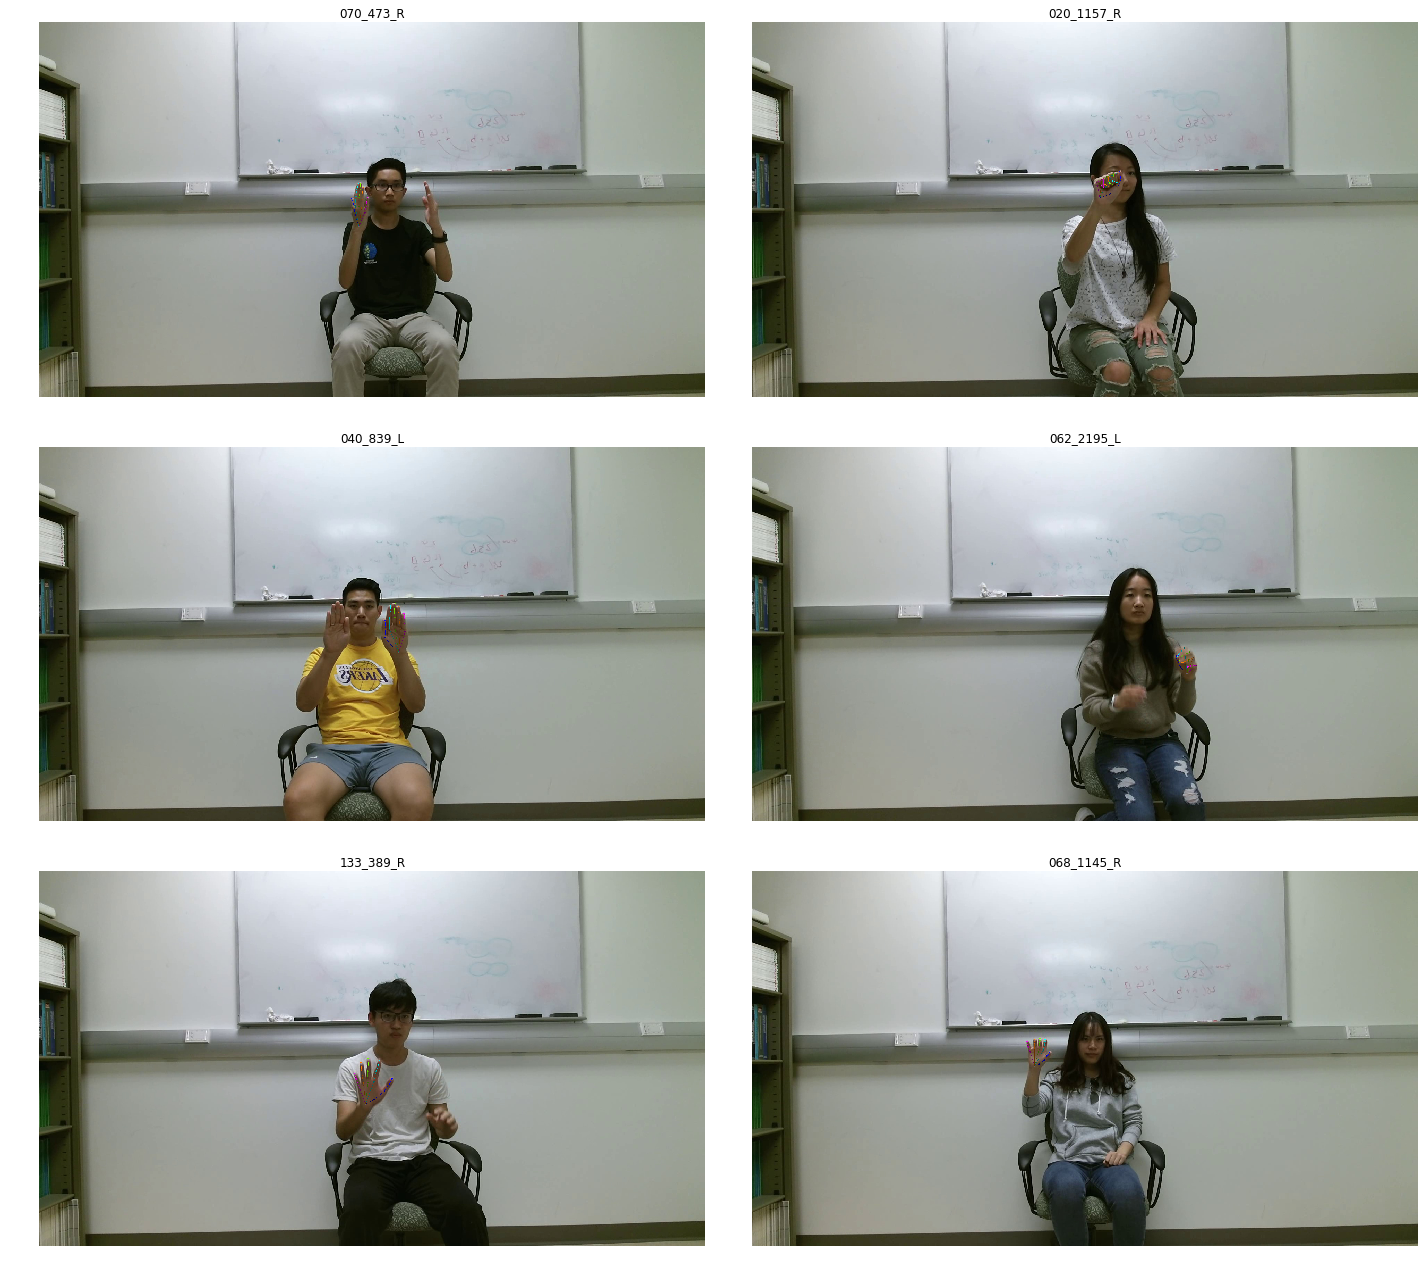

In [46]:
# DataLoader class to create a muli-process iterator and load data into memory faster
data = HandGestureDataset("Dataset/", transform=False)
dataloader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True, num_workers=2)

num = 6
fix, ax = plt.subplots(num//2, 2, figsize=(20, num*3))
ax = [a for b in ax for a in b] # wooooo


for i in range(len(data)):
    sample = data[i]
    
    plt.tight_layout()
    ax[i].set_title(sample['name'])
    ax[i].axis('off')
    
    
#     sample['image'] = cv2.cvtColor(sample['image'], cv2.COLOR_GRAY2RGB)
#     edges = cv2.Canny(sample['image'],100,200)
    
    canvas = show.draw_hand(sample['image'], sample['joints'])
    
#     ax[i].imshow(edges, cmap = 'gray')#[:,:,::-1])
    ax[i].imshow(canvas[:,:,::-1]) # image is bgr

    if i == num-1:
        plt.show()
        break

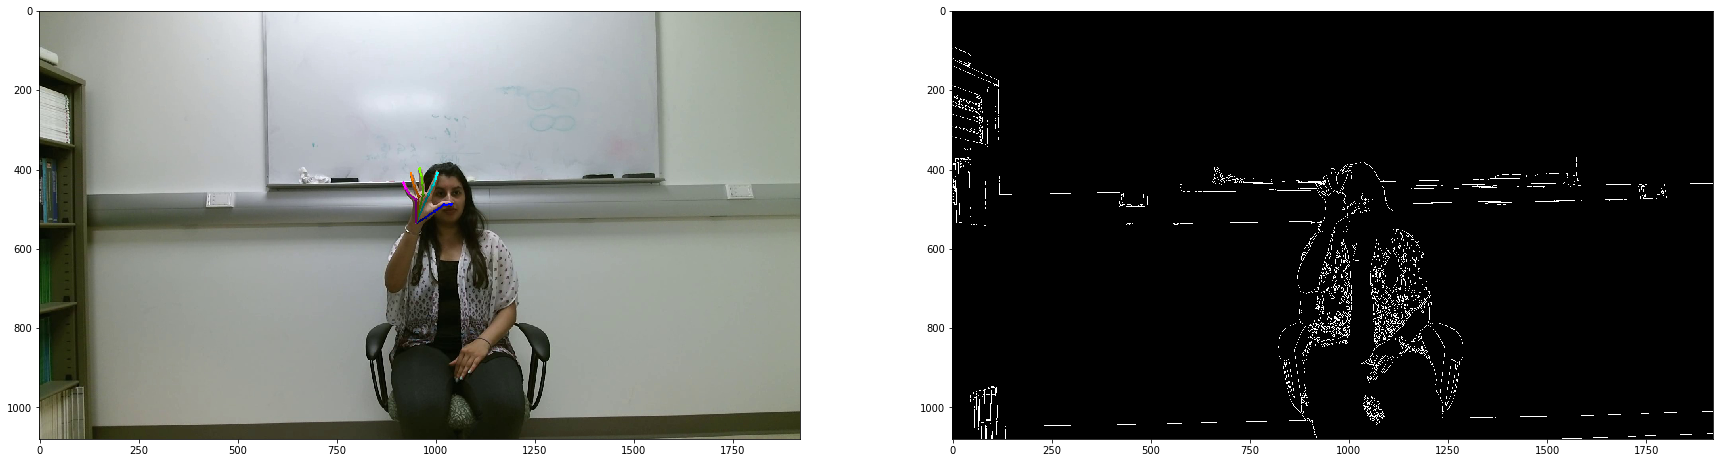

In [137]:
# shoft + tab = clutchhhhh
sample = data[i]
fig, ax = plt.subplots(1,2, figsize=(30, 20))
edges = cv2.Canny(sample['image'], 10, 300)
canvas = show.draw_hand(sample['image'], sample['joints'])
ax[0].imshow(sample['image'][:,:,::-1])
ax[1].imshow(edges, cmap = 'gray')
plt.show()

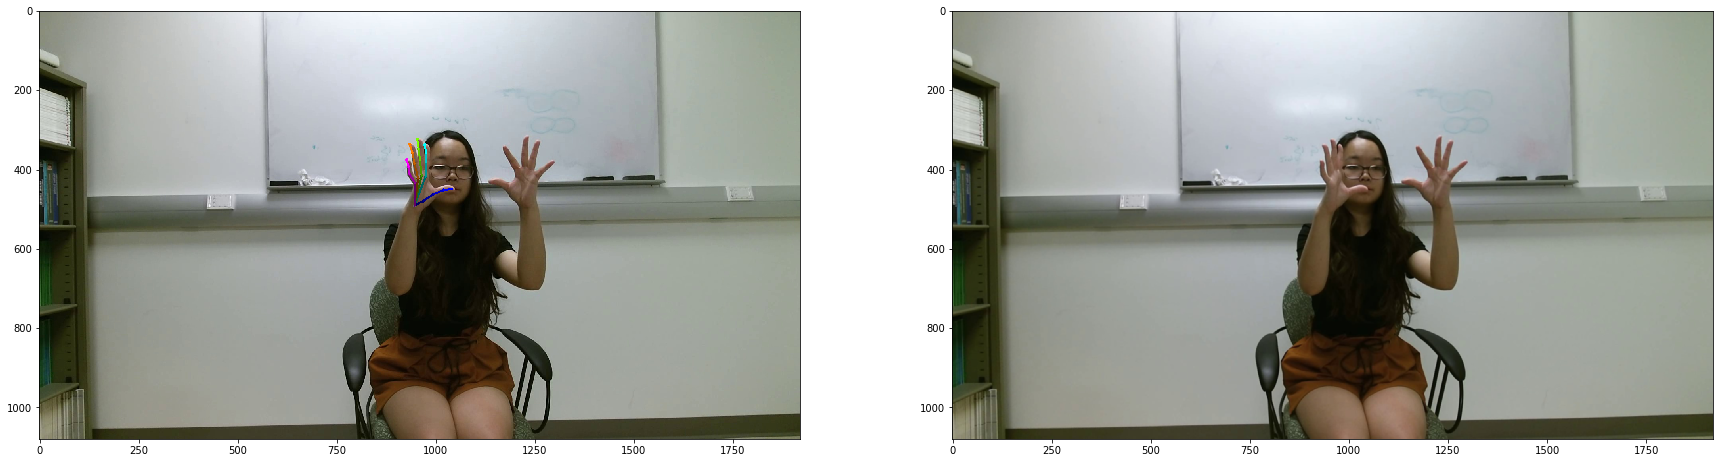

In [139]:
# Gaussian Blurring
sample = data[i]
fig, ax = plt.subplots(1,2, figsize=(30, 20))
blur = cv2.GaussianBlur(sample['image'], (5,5), 0)
canvas = show.draw_hand(sample['image'], sample['joints'])
ax[0].imshow(sample['image'][:,:,::-1])
ax[1].imshow(blur[:,:,::-1])
plt.show()

In [3]:
def transform_joint(joints):
    j_2 = []
    for J in joints:
        j_2.append([int(J[0]//2), int(J[1]//2)])
    return j_2

def center(joints):
    min_x = min(joints, key=lambda x : x[0])[0]
    max_x = max(joints, key=lambda x : x[0])[0]
    min_y = min(joints, key=lambda x : x[1])[1]
    max_y = max(joints, key=lambda x : x[1])[1]
    return (int((max_x-min_x)//2 + min_x), int((max_y-min_y)//2 + min_y))

21 joints
shape (128, 128)


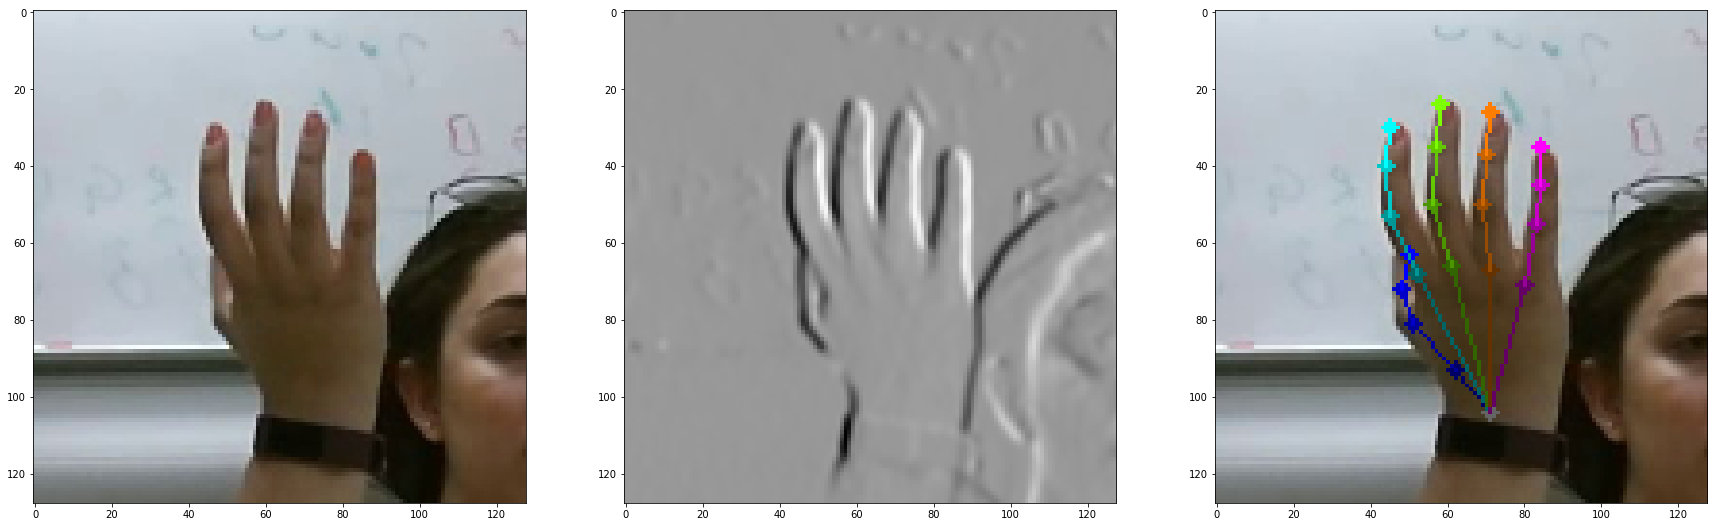

In [531]:
sample = data[i]
fig, ax = plt.subplots(1,3, figsize=(30, 15))

small = cv2.resize(sample['image'], (0,0), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA) # resize by half

gray = cv2.cvtColor(small, cv2.COLOR_BGR2GRAY)


j_2 = transform_joint(sample['joints'])
print len(j_2), 'joints'
_x, _y = center(j_2)
cropped = small[_y-64:_y+64 , _x-64:_x+64]
ax[0].imshow(cropped[:,:,::-1])


canvas = show.draw_hand(small, j_2)

gray_p = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
gray_cropped = gray_p[_y-64:_y+64 , _x-64:_x+64]
ax[1].imshow(gray_cropped)
print 'shape', gray_cropped.shape


ax[2].imshow(cropped[:,:,::-1])
plt.savefig("processing.png")
plt.show()

In [6]:
joints = json.load(open("Dataset/annotation.json","r"))
names = list(joints.keys())

In [7]:
print (len(names))

94126


In [ ]:
for i, name in enumerate(names):
    image = cv2.imread("Dataset/Color/" + name[:-2] + ".jpg")
    small = cv2.resize(image, (0,0), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA) # resize by half
    gray = cv2.cvtColor(small, cv2.COLOR_BGR2GRAY)
    j_2 = transform_joint(joints[name])
    _x, _y = center(j_2)
    cropped = small[_y-64:_y+64 , _x-64:_x+64]

    gray_p = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    gray_cropped = gray_p[_y-64:_y+64 , _x-64:_x+64]
    
    u,v = gray_cropped.shape
    
    if u != 128:
        gray_cropped = gray_p[gray.shape[0]-128:gray.shape[0] , _x-64:_x+64]

    cv2.imwrite('Dataset/ProcessedImages/' + name + '.png', gray_cropped)
        
    if i%1000 == 0:
        print(i)
#     print(gray_cropped.shape)
#     fig, ax = plt.subplots(1,1, figsize=(10, 10))
#     ax.imshow(gray_cropped)
#     plt.show()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000


In [5]:
joints = json.load(open("Dataset/scaled_annotations.json","r"))
names = list(joints.keys())

In [6]:
resize = []
for i, name in enumerate(names):
    image = cv2.imread("Dataset/ProcessedImages/" + name + ".png")
    if image.size != 49152:
        print(image.size)
        resize.append(name)

46080
36096
46080
46080
46848
46848
46848
43008
47232
46080
42240
41088
45696
46080
47616
46464
41088
39168
45696
44160
41088
42240
42624
41472
36864
45696
46464
45312
39552
47232
44928
42240
44160
48768
43776
42240
41472
43776
43008
46848
41472
41472
40320
43392
41088
46464
46848
43776
41472
42624
43392
46464
47616
47232
47232
43392
46080
47616
46464
48768
47232
44928
48768
45696
43008
42624
43392
48384
48768
44544
46464
47232
47616
48384
46464
47616
43776
48768
46464
41856
48768
33792
43392
41088
44928
46080
48000
48384
43008
41472
41856
48000
42240
45312
46080
43392
41472
48768
44160
48000
42624
46848
46848
42624
47232
46464
36480
41472
46848
46848
41472
46464
37248
46080
46848
41472
44928
41856
45696
45312
41088
47232
43392
44928
43392
45696
46848
44160
41088
39168
44928
42240
44160
46464
45312
43008
47232
44160
47232
45696
47232
42240
48768
45696
45696
43776
47232
47232
47232
45312
45696
45312
43008
46464
43008
46080
44928
41856
46848
46848
46464
47232
45312
46080
48768
47616
4684

In [74]:
scaled_joints = {}
for i, name in enumerate(names):
    j_2 = transform_joint(joints[name])
    u,v = center(j_2)
    
    sub_x = u-64
    sub_y = v-64
    
    for j in j_2:
        j[0] -= sub_x
        j[1] -= sub_y
        
    if i == 5:
        print(scaled_joints)
    
    scaled_joints[name] = j_2

{'007_1499_L': [[65, 99], [56, 93], [50, 85], [42, 79], [33, 77], [57, 65], [54, 55], [51, 44], [50, 36], [64, 63], [63, 46], [64, 37], [65, 29], [72, 63], [75, 50], [78, 42], [79, 33], [78, 69], [85, 60], [89, 55], [95, 48]], '072_2297_L': [[80, 47], [69, 49], [58, 53], [49, 62], [47, 67], [61, 51], [55, 61], [51, 69], [47, 76], [69, 54], [62, 66], [58, 75], [54, 81], [75, 57], [69, 70], [65, 77], [60, 82], [81, 60], [76, 70], [72, 75], [69, 78]], '066_1175_L': [[56, 35], [49, 47], [44, 61], [43, 71], [45, 82], [54, 60], [57, 74], [61, 84], [64, 93], [62, 54], [66, 67], [71, 77], [75, 85], [66, 49], [72, 58], [77, 65], [81, 73], [72, 45], [78, 50], [81, 52], [85, 55]], '028_389_R': [[61, 102], [72, 96], [82, 84], [86, 69], [90, 58], [69, 68], [69, 51], [70, 41], [70, 31], [61, 68], [60, 49], [59, 38], [60, 27], [54, 70], [52, 52], [51, 42], [51, 33], [48, 74], [44, 62], [41, 54], [38, 46]], '026_2063_R': [[44, 49], [56, 48], [69, 51], [79, 63], [85, 71], [68, 49], [78, 61], [82, 67], 

In [75]:
with open('scaled_annotations.json', 'w') as outfile:
    json.dump(scaled_joints, outfile)